## Índice

1. [Introducción y objetivos](#1-introducción-y-objetivos)
2. [Carga de datos y preparación](#2-carga-de-datos-y-preparación)
3. [Embeddings y indexación](#3-embeddings-y-indexación)
    - 3.1. [Embeddings MiniLM](#31-embeddings-minilm)
    - 3.2. [Embeddings MPNet](#32-embeddings-mpnet)
4. [Construcción y guardado de índices FAISS](#4-construcción-y-guardado-de-índices-faiss)
5. [Construcción del índice BM25](#4-construcción-del-índice-BM25)

---

## 1. Introducción y objetivos

En este notebook preparo y guardo los sistemas de recuperación sobre el corpus normativo ya procesado, usando tanto modelos de embeddings como BM25. El objetivo es dejar listos los índices y funciones de búsqueda para poder comparar métodos más adelante.

---

## 2. Carga de datos y preparación

Se carga el corpus procesado desde el archivo JSON y se extraen los textos, los IDs y los metadatos de cada chunk.


In [3]:
import json

with open("../data/chunks/corpus_chunks_300w.json", "r", encoding="utf-8") as f:
    corpus = json.load(f)

print(f"Número de chunks cargados: {len(corpus)}")
print("Ejemplo de chunk:")
print(corpus[0])


Número de chunks cargados: 357
Ejemplo de chunk:
{'pdf': 'oecd_ai_classification_framework.pdf', 'pages': [16], 'titles': ['16     OECD FRAMEWORK FOR THE CLASSIFICATION OF AI SYSTEMS'], 'chunk_index': 1, 'text': '16 OECD FRAMEWORK FOR THE CLASSIFICATION OF AI SYSTEMS OECD 2022 Different types of AI systems raise different policy opportunities and challenges. Section 2 of this report introduces and describes a framework to assess AI systems impact on public policy in areas covered by the OECD AI Principles (OECD, 2019d[1]). Section 3 puts the framework into use to classify specific AI systems and applications. Section 4 discusses how the framework could be used to help assess basic social, physical and ethical risks associated with specific types of AI systems. Introducing the framework and its purpose The framework primary purpose is to characterise the application of an AI system deployed in a specific project and context, although some dimensions are also relevant to generic AI syste

### Preparación de listas de textos, IDs y metadatos

Se separan los textos, los identificadores y los metadatos de cada chunk en listas distintas para que luego sea más fácil generar los embeddings, buscar resultados y mostrar información relevante.


In [5]:
texts = []
ids = []
metadatos = []

for i, chunk in enumerate(corpus):
    texts.append(chunk["text"])
    # ID único tipo "pdf_chunkindex"
    ids.append(f'{chunk["pdf"]}_{chunk["chunk_index"]}')
    # Metadatos
    meta = chunk.copy()
    meta.pop("text")
    metadatos.append(meta)

print(f"Ejemplo de texto: {texts[0][:80]}...")
print(f"Ejemplo de ID: {ids[0]}")
print(f"Ejemplo de metadatos: {metadatos[0]}")


Ejemplo de texto: 16 OECD FRAMEWORK FOR THE CLASSIFICATION OF AI SYSTEMS OECD 2022 Different types...
Ejemplo de ID: oecd_ai_classification_framework.pdf_1
Ejemplo de metadatos: {'pdf': 'oecd_ai_classification_framework.pdf', 'pages': [16], 'titles': ['16     OECD FRAMEWORK FOR THE CLASSIFICATION OF AI SYSTEMS'], 'chunk_index': 1, 'n_words': 300}


In [7]:
import os

os.makedirs("../data/chunks", exist_ok=True)

with open("../data/chunks/texts.json", "w", encoding="utf-8") as f:
    json.dump(texts, f, ensure_ascii=False, indent=2)

with open("../data/chunks/ids.json", "w", encoding="utf-8") as f:
    json.dump(ids, f, ensure_ascii=False, indent=2)

with open("../data/chunks/metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadatos, f, ensure_ascii=False, indent=2)

print("Listas guardadas en data/chunks/")


Listas guardadas en data/chunks/


---
## 3. Embeddings y indexación

Se generan los embeddings de cada chunk usando modelos preentrenados y se guardan para poder construir los índices y hacer búsquedas más adelante. MiniLM y MPNet.


In [8]:
from sentence_transformers import SentenceTransformer
import numpy as np
import time
import os
import json

os.makedirs("../data/embeddings", exist_ok=True)
os.makedirs("../results", exist_ok=True)

# Modelo MiniLM
model_minilm = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

start = time.time()
embeddings_minilm = model_minilm.encode(texts, show_progress_bar=True, batch_size=32, normalize_embeddings=True)
elapsed_minilm = time.time() - start

# Guardar embeddings
np.save("../data/embeddings/embeddings_minilm.npy", embeddings_minilm)

# Guardar tiempo
result_minilm = {"modelo": "all-MiniLM-L6-v2", "tiempo_segundos": elapsed_minilm, "n_chunks": len(texts)}
with open("../results/embeddings_time_minilm.json", "w") as f:
    json.dump(result_minilm, f, indent=2)

print(f"Embeddings MiniLM generados y guardados. Tiempo: {elapsed_minilm:.2f} s")


d:\TFM_RAG_NOR\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches:   0%|          | 0/12 [00:00<?, ?it/s]d:\TFM_RAG_NOR\venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 12/12 [00:29<00:00,  2.49s/it]

Embeddings MiniLM generados y guardados. Tiempo: 29.97 s


In [9]:
# Modelo MPNet
model_mpnet = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

start = time.time()
embeddings_mpnet = model_mpnet.encode(texts, show_progress_bar=True, batch_size=32, normalize_embeddings=True)
elapsed_mpnet = time.time() - start

# Guardar embeddings
np.save("../data/embeddings/embeddings_mpnet.npy", embeddings_mpnet)

# Guardar tiempo
result_mpnet = {"modelo": "all-mpnet-base-v2", "tiempo_segundos": elapsed_mpnet, "n_chunks": len(texts)}
with open("../results/embeddings_time_mpnet.json", "w") as f:
    json.dump(result_mpnet, f, indent=2)

print(f"Embeddings MPNet generados y guardados. Tiempo: {elapsed_mpnet:.2f} s")


Batches: 100%|██████████| 12/12 [05:33<00:00, 27.78s/it]


Embeddings MPNet generados y guardados. Tiempo: 333.45 s


Los embeddings de MiniLM se han generado en medio minuto y los de MPNet en algo más de 5 minutos. En ambos casos, el proceso ha sido sencillo y se han guardado los archivos y los tiempos para referencias.

---

## 4. Construcción y guardado de índices FAISS

Se construyen los índices FAISS para los embeddings generados y se guardan los archivos resultantes.


In [10]:
import faiss
import numpy as np
import os
import json

os.makedirs("../data/faiss_index", exist_ok=True)

embeddings_minilm = np.load("../data/embeddings/embeddings_minilm.npy")

# similar coseno con L2 normalizado)
dim = embeddings_minilm.shape[1]
index_minilm = faiss.IndexFlatIP(dim)
index_minilm.add(embeddings_minilm)

faiss.write_index(index_minilm, "../data/faiss_index/faiss_index_minilm.faiss")

print(f"Índice FAISS MiniLM guardado.")


Índice FAISS MiniLM guardado.


In [11]:
# MPNet
embeddings_mpnet = np.load("../data/embeddings/embeddings_mpnet.npy")

dim = embeddings_mpnet.shape[1]
index_mpnet = faiss.IndexFlatIP(dim)
index_mpnet.add(embeddings_mpnet)

faiss.write_index(index_mpnet, "../data/faiss_index/faiss_index_mpnet.faiss")

print(f"Índice FAISS MPNet guardado.")


Índice FAISS MPNet guardado.


### 4.1 Verificación básica de los embeddings

Se comprueba que los embeddings tienen la forma esperada y que no hay valores raros o repetidos.

In [15]:
import numpy as np

# Cargar embeddings MiniLM y MPNet
embeddings_minilm = np.load("../data/embeddings/embeddings_minilm.npy")
embeddings_mpnet = np.load("../data/embeddings/embeddings_mpnet.npy")

# Shape esperado
print("MiniLM shape:", embeddings_minilm.shape)
print("MPNet shape:", embeddings_mpnet.shape)

# Comprobar valores NaN
print("MiniLM tiene NaN:", np.isnan(embeddings_minilm).any())
print("MPNet tiene NaN:", np.isnan(embeddings_mpnet).any())

# filas idénticas
mini_dupes = np.unique(embeddings_minilm, axis=0).shape[0] != embeddings_minilm.shape[0]
mpnet_dupes = np.unique(embeddings_mpnet, axis=0).shape[0] != embeddings_mpnet.shape[0]
print("MiniLM tiene filas idénticas:", mini_dupes)
print("MPNet tiene filas idénticas:", mpnet_dupes)

print("MiniLM min/max:", embeddings_minilm.min(), embeddings_minilm.max())
print("MPNet min/max:", embeddings_mpnet.min(), embeddings_mpnet.max())

MiniLM shape: (357, 384)
MPNet shape: (357, 768)
MiniLM tiene NaN: False
MPNet tiene NaN: False
MiniLM tiene filas idénticas: False
MPNet tiene filas idénticas: False
MiniLM min/max: -0.24611469 0.23589705
MPNet min/max: -0.17242333 0.18466605


Los embeddings de ambos modelos tienen la forma esperada y no hay valores raros ni filas repetidas. Todo OK.

### 4.2 Comprobación del funcionamiento del índice FAISS

Se verifica que el índice FAISS carga bien y que, buscando el embedding de un chunk, se recupera correctamente a sí mismo en primer lugar.


In [16]:
import faiss

index_minilm = faiss.read_index("../data/faiss_index/faiss_index_minilm.faiss")

# Buscar el embedding de un chunk concreto
query_vec = embeddings_minilm[0].reshape(1, -1)
D, I = index_minilm.search(query_vec, k=5)  # k=5 para ver top resultados

print("Top-5 índices recuperados:", I[0])
print("Distancias/similaridades:", D[0])
print("¿El primero recuperado es el mismo chunk?", I[0][0] == 0)


Top-5 índices recuperados: [ 0 11  1  9 19]
Distancias/similaridades: [1.         0.83720756 0.79155463 0.7829906  0.7818232 ]
¿El primero recuperado es el mismo chunk? True


El índice FAISS recupera correctamente el propio chunk como el más similar. Los vecinos cercanos también tienen valores altos de similitud, así que parece que la indexación está bien.

### 4.3 Exploración de similitud entre chunks

Se calculan las similitudes entre algunos chunks al azar para ver si hay diferencias claras según el origen del PDF.


In [17]:
import random

i = random.randint(0, len(embeddings_minilm)-1)
# Buscar otro del mismo PDF
pdf_actual = metadatos[i]["pdf"]
mismos_pdf = [idx for idx, m in enumerate(metadatos) if m["pdf"] == pdf_actual and idx != i]
distinto_pdf = [idx for idx, m in enumerate(metadatos) if m["pdf"] != pdf_actual]

if mismos_pdf and distinto_pdf:
    j = random.choice(mismos_pdf)
    k = random.choice(distinto_pdf)

    # Producto escalar
    sim_same = float(np.dot(embeddings_minilm[i], embeddings_minilm[j]))
    sim_diff = float(np.dot(embeddings_minilm[i], embeddings_minilm[k]))
    print(f"Similitud entre chunks del mismo PDF: {sim_same:.4f}")
    print(f"Similitud entre chunks de PDFs distintos: {sim_diff:.4f}")
else:
    print("No se encuentran chunks adecuados para la comparación.")


Similitud entre chunks del mismo PDF: 0.4871
Similitud entre chunks de PDFs distintos: 0.3119


La similitud entre chunks del mismo PDF es más alta que entre PDFs distintos. Esto tiene sentido, ya que suelen estar más relacionados. Los valores no son extremos.

### 4.4 Visualización rápida de los embeddings

Se representa una proyección 2D (PCA) de los embeddings para ver si se agrupan por documento o si están dispersos.


In [19]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- -----------------------------

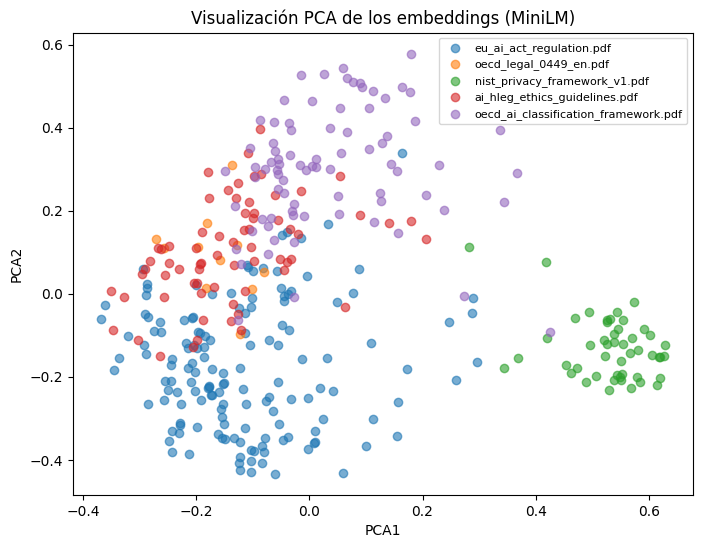

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Hacemos PCA a 2D para MiniLM
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_minilm)

# Etiqueta por PDF
pdf_names = [meta["pdf"] for meta in metadatos]
pdfs_unicos = list(set(pdf_names))
colors = {pdf: i for i, pdf in enumerate(pdfs_unicos)}

plt.figure(figsize=(8, 6))
for pdf in pdfs_unicos:
    idxs = [i for i, p in enumerate(pdf_names) if p == pdf]
    plt.scatter(embeddings_pca[idxs, 0], embeddings_pca[idxs, 1], label=pdf, alpha=0.6)
plt.legend(fontsize=8)
plt.title("Visualización PCA de los embeddings (MiniLM)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


Los embeddings de los chunks se agrupan bastante por documento.

---

## 5. Construcción del índice BM25

Se crea el índice BM25 a partir de los textos de los chunks, usando tokenización simple. Así se puede comparar la recuperación o usar recuperación híbrida.


In [12]:
!pip install rank_bm25

In [13]:
from rank_bm25 import BM25Okapi
import os
import pickle

tokenized_texts = [text.split() for text in texts]

# índice BM25
bm25 = BM25Okapi(tokenized_texts)

os.makedirs("../data/bm25", exist_ok=True)
with open("../data/bm25/bm25_index.pkl", "wb") as f:
    pickle.dump(bm25, f)

print("Índice BM25 creado y guardado.")


Índice BM25 creado y guardado.
